# Setup Packages

## If Working on Local Environment

***Check README FILE***

## If Working on Colab

In [1]:
!curl "https://drive.usercontent.google.com/download?id={10tkHjBkhzV_RUExS0J1jLfqiabpJfVfI}&confirm=xxx" -o "task1.zip"
import zipfile, os
with zipfile.ZipFile("./task1.zip", 'r') as z:
    z.extractall('.')

os.remove("task1.zip")
print("Zip file unzipped and deleted successfully.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 71530  100 71530    0     0  68066      0  0:00:01  0:00:01 --:--:-- 68123
Zip file unzipped and deleted successfully.


In [2]:
!pip install -e . > /dev/null 2>&1

# Import Packages

In [3]:
from WildfireLogan import convLSTM
from WildfireLogan import download
import numpy as np
import torch
import os
from torch.utils.data import DataLoader

# Download Data from Google Drive

## Download and Unzip train and test data

In [4]:
download.download_file('1Q4gn7Lq3sX1qVo05QpBr7nhBraJa9RXO', "Ferguson_fire_train.zip")
download.download_file('1nDOD5WS46hv532U6T94RIP_BdHiiAl_Z', "Ferguson_fire_test.zip")
download.unzip("Ferguson_fire_train.zip")
download.unzip("Ferguson_fire_test.zip")
os.remove("Ferguson_fire_train.zip")
os.remove("Ferguson_fire_test.zip")

Download successful, saved to Ferguson_fire_train.zip
Download successful, saved to Ferguson_fire_test.zip


## Download and Unzip Model and Observation data

In [5]:
download.download_file('1lEBir-M3AmuI6mgAnms_t70PZHjBizP_', "Ferguson_fire_background.zip")
download.unzip("Ferguson_fire_background.zip")
os.remove("Ferguson_fire_background.zip")
download.download_file('1iC4lTWN-w5eSVbbC16WDa002AoFg4kQa', "Ferguson_fire_obs.npy")

Download successful, saved to Ferguson_fire_background.zip
Download successful, saved to Ferguson_fire_obs.npy


# Load Data, Create Dataset and Data Loader

## Load Data

In [6]:
train_data = np.load('Ferguson_fire_train/Ferguson_fire_train.npy')
test_data = np.load('Ferguson_fire_test/Ferguson_fire_test.npy')
data_obs = np.load('Ferguson_fire_obs.npy')
data_model = np.load('Ferguson_fire_background/Ferguson_fire_background.npy')

## Create Dataset and Loader

### Train and Val Set

In [10]:
input_indices, target_indices = convLSTM.Input_target_Split(size=12500, seq=4, step_size=10, period=100, target_length=1)
train_dataset = convLSTM.SeqDataset(train_data, input_indices, target_indices, oneD=False)

In [11]:
train_subset, val_subset = convLSTM.train_test_split(train_dataset)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

### Test Set

In [12]:
test_input_indices, test_target_indices = convLSTM.Input_target_Split(size=5000, seq=4, step_size=10, period=100, target_length=1)
test_dataset = convLSTM.SeqDataset(test_data, test_input_indices, test_target_indices, oneD=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Using batch_size=1 for simplicity

# convLSTM Model

In [13]:
input_dim = 1
hidden_dim = [32, 32]  # Reduced number of filters
kernel_size = (3, 3)
num_layers = 2  # Reduced number of layers
image_size = (128, 128)  # Reduced image size
seq_length = 4
batch_size = 16  # Reduced batch size
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = convLSTM.ConvLSTMNetwork(input_dim=input_dim,
                        hidden_dim=hidden_dim,
                        kernel_size=kernel_size,
                        num_layers=num_layers,
                        image_size=image_size,
                        batch_first=True).to(device)

## Load a trained model

If you do not want to train the model from scatch, use below cells to download and load a well-trained model

In [14]:
download.download_file('1ojOnVDd2S9G3HueuM03P-YCNesC-yO9n', 'convLSTM.pth')

Download successful, saved to convLSTM.pth


In [15]:
model.load_state_dict(torch.load('convLSTM.pth', map_location=device))

<All keys matched successfully>

## Train the model

If you've already load a well trained model, you do not need to run these codes for training

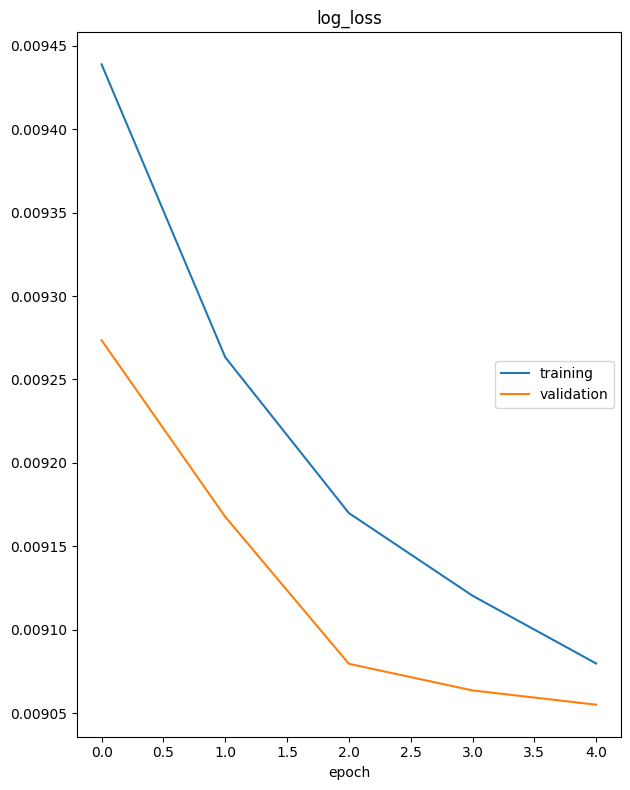

log_loss
	training         	 (min:    0.009, max:    0.009, cur:    0.009)
	validation       	 (min:    0.009, max:    0.009, cur:    0.009)
Epoch 5/5 - Train Loss: 0.0091 - Val Loss: 0.0091


In [27]:
convLSTM.train_model(model, train_loader, val_loader, device, num_epochs=5)

# Make Prediction and Evaluate the result

## Background data

### Make Prediction

In [28]:
predicted_img_model = convLSTM.prediction_on_background(model, data_model, device)

### Evaluate in terms of mse

In [29]:
convLSTM.compare_mse(predicted_img_model, data_model[-1])

0.01759231

### Evaluate in terms of plotting

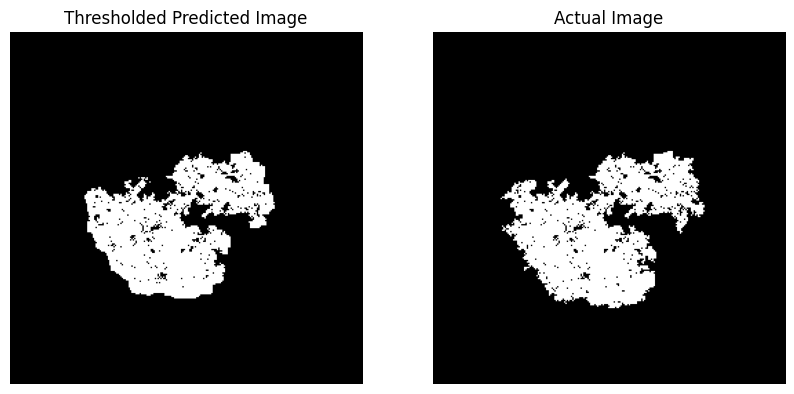

In [30]:
convLSTM.show_images(predicted_img_model, data_model[-1])

### Save thresholded image

In [31]:
np.save('LSTMimage.npy', np.where(predicted_img_model > 0.5, 1, 0))

## Prediction on Observation data

In [32]:
predicted_img_obs = convLSTM.prediction_on_background(model, data_obs, device)

### Evaluate in terms of mse

In [33]:
convLSTM.compare_mse(predicted_img_obs, data_obs[-1])

0.008765419525624332

### Evaluate in terms of plotting

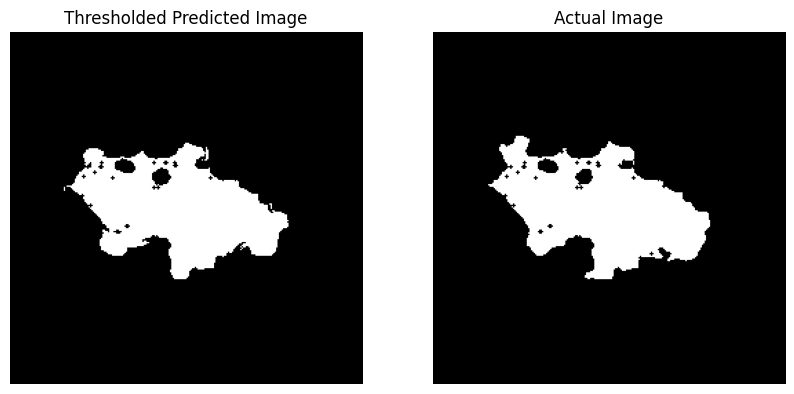

In [34]:
convLSTM.show_images(predicted_img_obs, data_obs[-1])

## Prediction on Random Test Set Data

In [35]:
predicted_img_test, target = convLSTM.prediction_on_test(model, test_loader, device)

### Evaluate in terms of mse

In [36]:
convLSTM.compare_mse(predicted_img_test, target)

2.1957076e-05

### Evaluate in terms of plotting

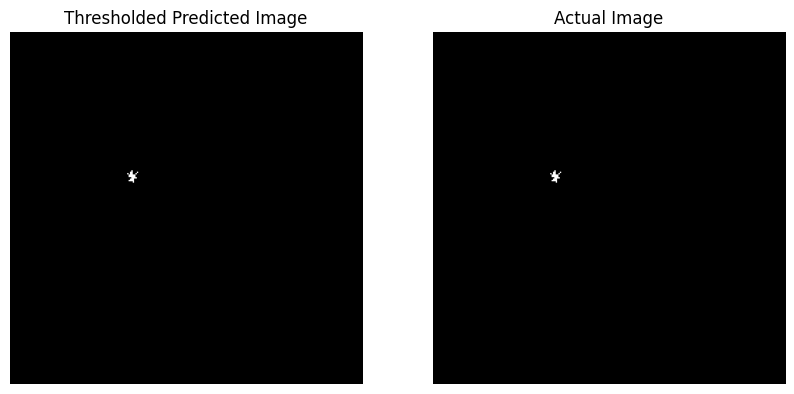

In [37]:
convLSTM.show_images(predicted_img_test, target)